# Ungraded assignment 5 - extra credit - All in one file

In [0]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [0]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [0]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [0]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [11]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch + 1,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        test_loss.result(),
                        test_accuracy.result() * 100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.137966126203537, Accuracy: 95.82167053222656, Test Loss: 0.06535845994949341, Test Accuracy: 97.86000061035156
Epoch 2, Loss: 0.04393551126122475, Accuracy: 98.66832733154297, Test Loss: 0.048336029052734375, Test Accuracy: 98.38999938964844
Epoch 3, Loss: 0.02367701567709446, Accuracy: 99.22000122070312, Test Loss: 0.05336085706949234, Test Accuracy: 98.33999633789062
Epoch 4, Loss: 0.013197639025747776, Accuracy: 99.55333709716797, Test Loss: 0.06053147092461586, Test Accuracy: 98.25


In [12]:
# Use seaborn for pairplot
!pip install -q seaborn

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [13]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [15]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.2.0


In [0]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [17]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 2us/step


'/root/.keras/datasets/auto-mpg.data'

In [18]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [19]:
dataset.isna().sum()


MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
dataset = dataset.dropna()


In [0]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})


In [22]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

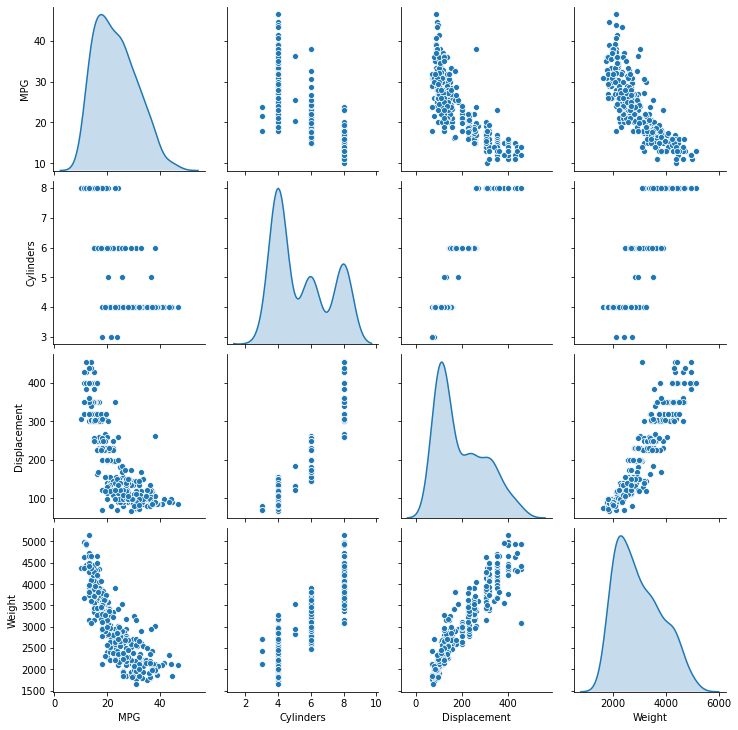

In [24]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")


In [25]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
model = build_model()


In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [31]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.16084796],
       [-0.2837237 ],
       [-0.5032326 ],
       [-0.24128126],
       [-0.4147163 ],
       [-0.19095679],
       [-0.46771413],
       [-0.85539275],
       [-0.24289122],
       [-0.33819103]], dtype=float32)

In [33]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:290.2310,  mae:15.7695,  mse:290.2310,  val_loss:245.0657,  val_mae:14.2837,  val_mse:245.0657,  
....................................................................................................
Epoch: 100, loss:5.7371,  mae:1.6756,  mse:5.7371,  val_loss:8.1952,  val_mae:2.2086,  val_mse:8.1952,  
....................................................................................................
Epoch: 200, loss:4.9631,  mae:1.4929,  mse:4.9631,  val_loss:8.7483,  val_mae:2.1554,  val_mse:8.7483,  
....................................................................................................
Epoch: 300, loss:4.4878,  mae:1.4269,  mse:4.4878,  val_loss:8.5498,  val_mae:2.1923,  val_mse:8.5498,  
....................................................................................................
Epoch: 400, loss:3.8405,  mae:1.3313,  mse:3.8405,  val_loss:8.4458,  val_mae:2.2635,  val_mse:8.4458,  
..............................................................

In [34]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.097914,0.931060,2.097914,8.460946,2.249607,8.460946,995
996,1.921638,0.853754,1.921638,8.658735,2.257607,8.658735,996
997,2.037340,0.900862,2.037340,8.722754,2.275146,8.722754,997
998,2.100396,0.907063,2.100396,9.703059,2.487005,9.703059,998
999,2.095673,0.954716,2.095673,8.623815,2.339257,8.623815,999


In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)


Text(0, 0.5, 'MAE [MPG]')

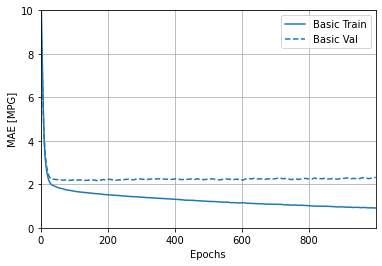

In [36]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

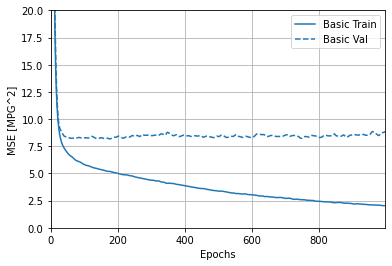

In [37]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [38]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:556.5635,  mae:22.1881,  mse:556.5635,  val_loss:538.7933,  val_mae:21.7270,  val_mse:538.7933,  
...........................................................................

Text(0, 0.5, 'MAE [MPG]')

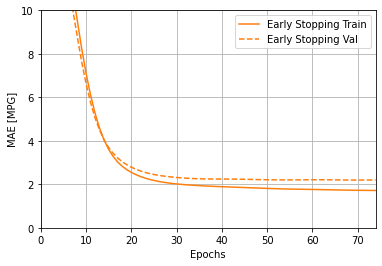

In [39]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [40]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.6460 - mae: 1.9006 - mse: 5.6460
Testing set Mean Abs Error:  1.90 MPG


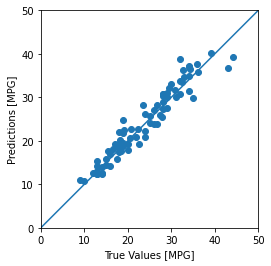

In [42]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

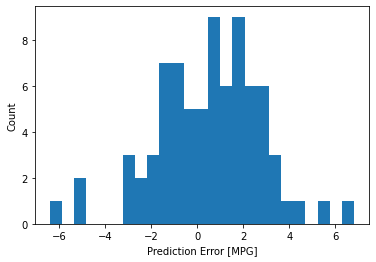

In [43]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [44]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.2.0


In [45]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [48]:
train_images.shape


(60000, 28, 28)

In [49]:
len(train_labels)


60000

In [50]:
train_labels


array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [51]:
test_images.shape


(10000, 28, 28)

In [52]:
len(test_labels)


10000

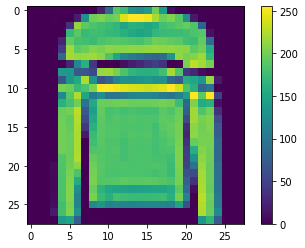

In [60]:
plt.figure()
plt.imshow(train_images[5])
plt.colorbar()
plt.grid(False)
plt.show()

In [0]:
train_images = train_images / 255.0

test_images = test_images / 255.0

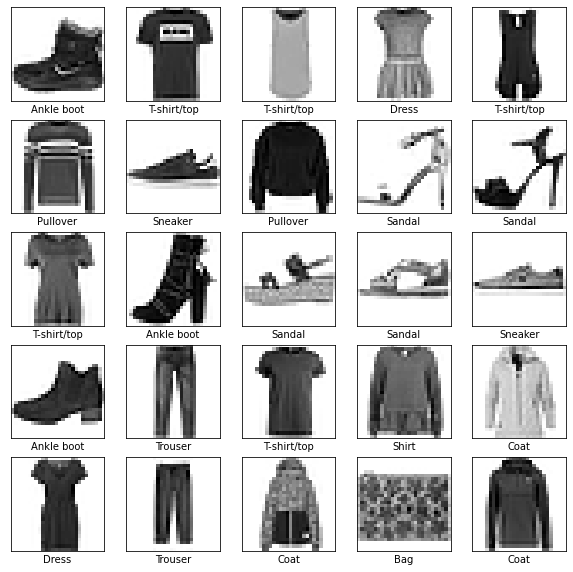

In [62]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)
])

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [65]:
model.fit(train_images, train_labels, epochs=10)


Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4965 - accuracy: 0.8253
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3750 - accuracy: 0.8639
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3331 - accuracy: 0.8785
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3132 - accuracy: 0.8856
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2935 - accuracy: 0.8935
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2805 - accuracy: 0.8960
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2709 - accuracy: 0.8984
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2584 - accuracy: 0.9036
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2483 - accuracy: 0.9074
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.240

In [66]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.3309 - accuracy: 0.8848

Test accuracy: 0.8848000168800354


In [0]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [0]:
predictions = probability_model.predict(test_images)


In [69]:
predictions[0]

array([2.4053866e-06, 6.4213075e-09, 4.4884505e-09, 1.0267955e-08,
       9.9853175e-09, 3.6249353e-04, 4.3170589e-06, 1.3847637e-02,
       1.2456211e-08, 9.8578310e-01], dtype=float32)

In [70]:
predictions[1] # to test it

array([8.3613457e-05, 5.3581585e-15, 9.9599969e-01, 1.6420675e-10,
       3.3914696e-03, 8.9041734e-16, 5.2522268e-04, 3.1667389e-17,
       3.2295274e-11, 1.1981625e-11], dtype=float32)

In [71]:
np.argmax(predictions[0])

9

In [72]:
np.argmax(predictions[1]) # to test it

2

In [73]:
test_labels[0]


9

In [74]:
test_labels[1]


2

In [0]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

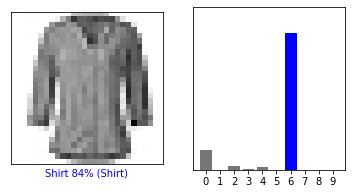

In [77]:
i = 4
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

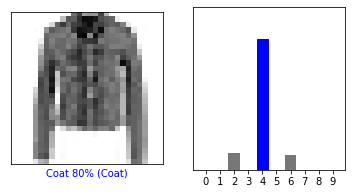

In [80]:
i = 10
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

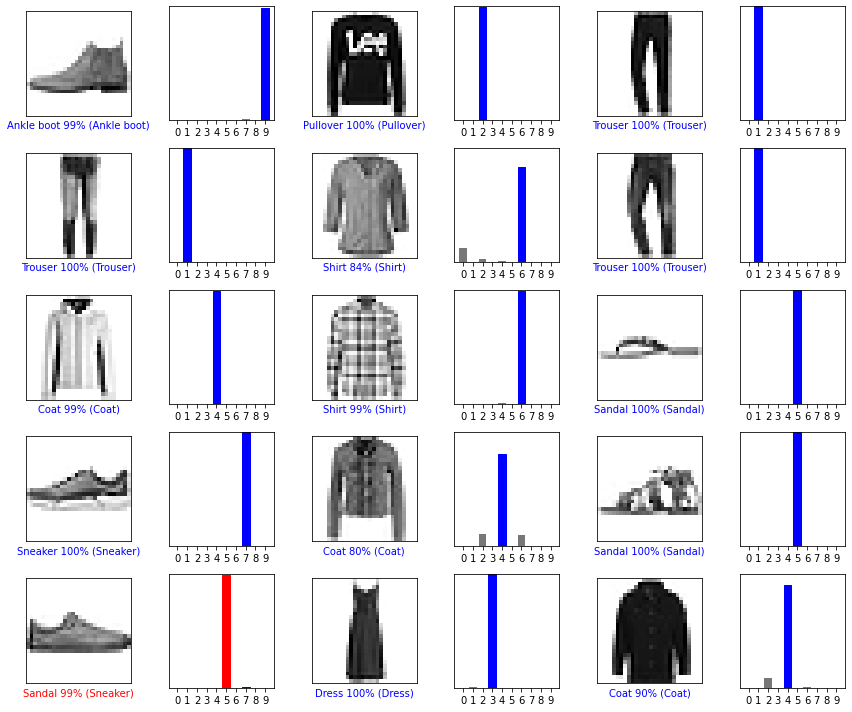

In [81]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

In [82]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


In [83]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [84]:
predictions_single = probability_model.predict(img)

print(predictions_single)

[[8.3613537e-05 5.3581585e-15 9.9599969e-01 1.6420675e-10 3.3914726e-03
  8.9042073e-16 5.2522169e-04 3.1667270e-17 3.2295149e-11 1.1981624e-11]]


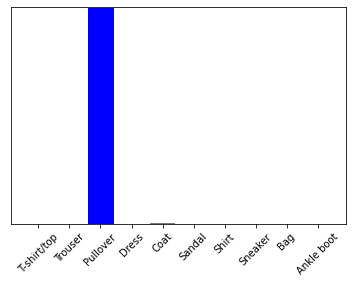

In [85]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [86]:
np.argmax(predictions_single[0])

2

In [87]:
import numpy as np

import tensorflow as tf

!pip install -q tensorflow-hub
!pip install -q tfds-nightly
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")


     |████████████████████████████████| 3.3MB 2.8MB/s 
Version:  2.2.0
Eager mode:  True
Hub version:  0.8.0
GPU is NOT AVAILABLE


In [88]:
# Split the training set into 60% and 40%, so we'll end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5HZ9RO/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5HZ9RO/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5HZ9RO/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [90]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

In [91]:
train_labels_batch


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

In [92]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 1.765786  , -3.882232  ,  3.9134233 , -1.5557289 , -3.3362343 ,
        -1.7357955 , -1.9954445 ,  1.2989551 ,  5.081598  , -1.1041286 ,
        -2.0503852 , -0.72675157, -0.65675956,  0.24436149, -3.7208383 ,
         2.0954835 ,  2.2969332 , -2.0689783 , -2.9489717 , -1.1315987 ],
       [ 1.8804485 , -2.5852382 ,  3.4066997 ,  1.0982676 , -4.056685  ,
        -4.891284  , -2.785554  ,  1.3874227 ,  3.8476458 , -0.9256538 ,
        -1.896706  ,  1.2113281 ,  0.11474707,  0.76209456, -4.8791065 ,
         2.906149  ,  4.7087674 , -2.3652055 , -3.5015898 , -1.6390051 ],
       [ 0.71152234, -0.6353217 ,  1.7385626 , -1.1168286 , -0.5451594 ,
        -1.1808156 ,  0.09504455,  1.4653089 ,  0.66059524,  0.79308075,
        -2.2268345 ,  0.07446612, -1.4075904 , -0.70645386, -1.907037  ,
         1.4419787 ,  1.9551861 , -0.42660055, -2.8022065 ,  0.43727064]],
      dtype=float32)>

In [93]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense_10 (Dense)             (None, 16)                336       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [95]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=5,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/5
30/30 [==============================] - 3s 103ms/step - loss: 1.7252 - accuracy: 0.5080 - val_loss: 0.6657 - val_accuracy: 0.5752
Epoch 2/5
30/30 [==============================] - 3s 99ms/step - loss: 0.6476 - accuracy: 0.6365 - val_loss: 0.6242 - val_accuracy: 0.6346
Epoch 3/5
30/30 [==============================] - 3s 108ms/step - loss: 0.6078 - accuracy: 0.6377 - val_loss: 0.6013 - val_accuracy: 0.6499
Epoch 4/5
30/30 [==============================] - 3s 109ms/step - loss: 0.5834 - accuracy: 0.6653 - val_loss: 0.5812 - val_accuracy: 0.6667
Epoch 5/5
30/30 [==============================] - 3s 112ms/step - loss: 0.5606 - accuracy: 0.6879 - val_loss: 0.5614 - val_accuracy: 0.6870


In [96]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 3s - loss: 0.5671 - accuracy: 0.6828
loss: 0.567
accuracy: 0.683


In [97]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.2.0


In [98]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [0]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [0]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [101]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')


2816409600/2816407858 [==============================] - 65s 0us/step


In [0]:
FEATURES = 28


In [0]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")


In [0]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [0]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()


tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


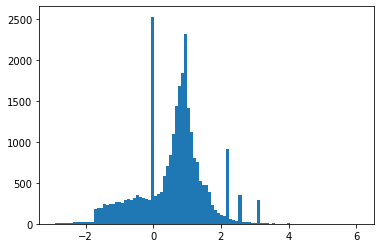

In [107]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [0]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [0]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [110]:
train_ds


<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [0]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [0]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

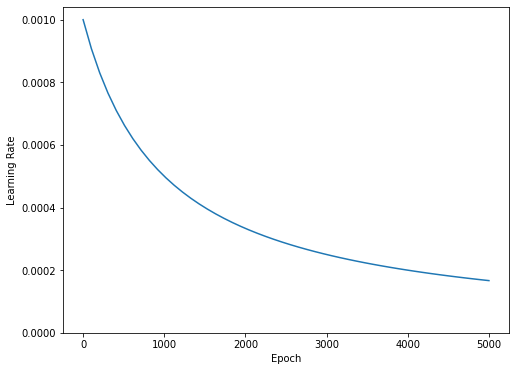

In [113]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [0]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [0]:
def compile_and_fit(model, name, optimizer=None, max_epochs=100):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

In [0]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [0]:
size_histories = {}

In [118]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                464       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4831,  binary_crossentropy:0.7963,  loss:0.7963,  val_accuracy:0.4770,  val_binary_crossentropy:0.7773,  val_loss:0.7773,  
....................................................................................................
Epoch: 100, accuracy:0.6029,  binary_crossentropy:0.6241,  loss:0.6241,  val_accuracy:0.5710,  val_binary_crossentropy:0.6279,  val_loss:0.6279,  
....................................................................................................
Epoch: 200, accuracy:0.

(0.5, 0.7)

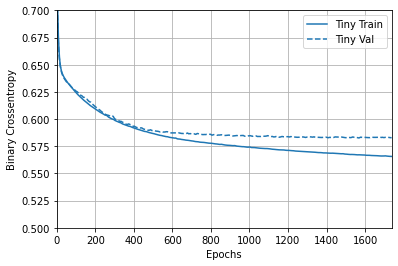

In [119]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [0]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [121]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 16)                464       
_________________________________________________________________
dense_15 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5127,  binary_crossentropy:0.7618,  loss:0.7618,  val_accuracy:0.5140,  val_binary_crossentropy:0.6968,  val_loss:0.6968,  
....................................................................................................
Epoch: 100, accuracy:0.6189,  binary_crossentropy:0.6130,  loss:0.6130,  val_accuracy:0.6180,  val_binary_crossentropy:0.6208,  val_loss:0.

In [0]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [123]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                1856      
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4919,  binary_crossentropy:0.7002,  loss:0.7002,  val_accuracy:0.4550,  val_binary_crossentropy:0.6831,  val_loss:0.6831,  
....................................................................................................
E

In [0]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [125]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_24 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5048,  binary_crossentropy:0.8271,  loss:0.8271,  val_accuracy:0.4790,  val_binary_crossentr

Text(0.5, 0, 'Epochs [Log Scale]')

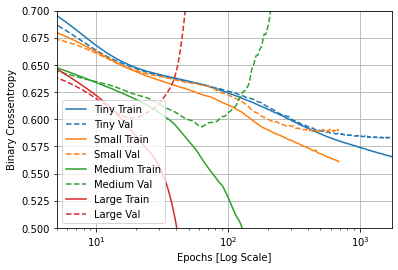

In [126]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [132]:
!pip install -U tensorboard

Requirement already up-to-date: tensorboard in /usr/local/lib/python3.6/dist-packages (2.2.1)


In [128]:
%tensorboard --logdir logs/sizes


UsageError: Line magic function `%tensorboard` not found.


In [0]:
# display.IFrame(
#     src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
#     width="100%", height="800px")

In [0]:
#!tensorboard dev upload --logdir  logs/sizes
##!tensorboard dev upload --logdir logs --name "Graded Homework 5- extra credit" --description ""

In [134]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmpwajjzjog/tensorboard_logs/regularizers/Tiny')

In [0]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [136]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_27 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_28 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_29 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5086,  binary_crossentropy:0.7728,  loss:2.2756,  val_accuracy:0.4760,  val_binary_crossentr

(0.5, 0.7)

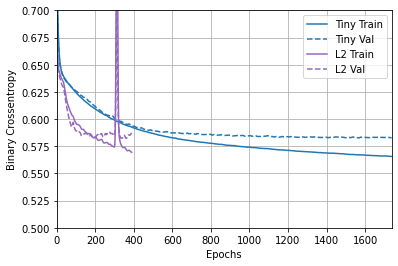

In [137]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [0]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

In [144]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),

    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 513       
Total params: 278,017
Trainable params: 278,017
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5247,  binary_crossentropy:0.7298,  loss:0.7298,  val_accuracy:0.5030,  val_binary_crossent

(0.5, 0.7)

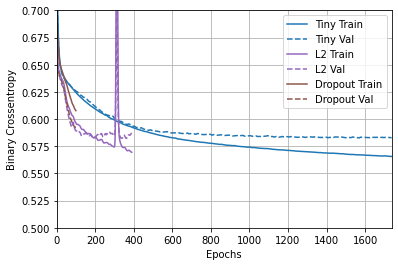

In [145]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [146]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 512)             

(0.5, 0.7)

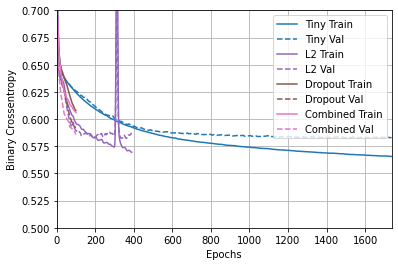

In [147]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [0]:
# %tensorboard --logdir {logdir}/regularizers


In [0]:
# display.IFrame(
#     src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
#     width = "100%",
#     height="800px")

In [0]:
# tensorboard dev upload --logdir  {logdir}/regularizers


# Save and load models

In [0]:
pip install -q pyyaml h5py  # Required to save models in HDF5 format


In [149]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.2.0


In [0]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_labels = train_labels[:1000]
test_labels = test_labels[:1000]

train_images = train_images[:1000].reshape(-1, 28 * 28) / 255.0
test_images = test_images[:1000].reshape(-1, 28 * 28) / 255.0

In [151]:
# Define a simple sequential model
def create_model():
  model = tf.keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10)
  ])

  model.compile(optimizer='adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [152]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
model.fit(train_images, 
          train_labels,  
          epochs=10,
          validation_data=(test_images,test_labels),
          callbacks=[cp_callback])  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.

Epoch 1/10
26/32 [=======================>......] - ETA: 0s - loss: 1.1878 - accuracy: 0.6743
Epoch 00001: saving model to training_1/cp.ckpt
32/32 [==============================] - 0s 10ms/step - loss: 1.0848 - accuracy: 0.7050 - val_loss: 0.6840 - val_accuracy: 0.7890
Epoch 2/10
26/32 [=======================>......] - ETA: 0s - loss: 0.4334 - accuracy: 0.8678
Epoch 00002: saving model to training_1/cp.ckpt
32/32 [==============================] - 1s 24ms/step - loss: 0.4176 - accuracy: 0.8720 - val_loss: 0.5128 - val_accuracy: 0.8420
Epoch 3/10
27/32 [========================>.....] - ETA: 0s - loss: 0.2919 - accuracy: 0.9155
Epoch 00003: saving model to training_1/cp.ckpt
32/32 [==============================] - 0s 10ms/step - loss: 0.2858 - accuracy: 0.9180 - val_loss: 0.4734 - val_accuracy: 0.8600
Epoch 4/10
28/32 [=========================>....] - ETA: 0s - loss: 0.2039 - accuracy: 0.9509
Epoch 00004: saving model to training_1/cp.ckpt
32/32 [==============================] - 0

In [0]:
# ls {checkpoint_dir}


In [153]:
# Create a basic model instance
model = create_model()

# Evaluate the model
loss, acc = model.evaluate(test_images,  test_labels, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

32/32 - 0s - loss: 2.4054 - accuracy: 0.0700
Untrained model, accuracy:  7.00%


In [154]:
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss,acc = model.evaluate(test_images,  test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

32/32 - 0s - loss: 0.3986 - accuracy: 0.8710
Restored model, accuracy: 87.10%


In [155]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=5)

# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model.fit(train_images, 
          train_labels,
          epochs=50, 
          callbacks=[cp_callback],
          validation_data=(test_images,test_labels),
          verbose=0)


Epoch 00005: saving model to training_2/cp-0005.ckpt

Epoch 00010: saving model to training_2/cp-0010.ckpt

Epoch 00015: saving model to training_2/cp-0015.ckpt

Epoch 00020: saving model to training_2/cp-0020.ckpt

Epoch 00025: saving model to training_2/cp-0025.ckpt

Epoch 00030: saving model to training_2/cp-0030.ckpt

Epoch 00035: saving model to training_2/cp-0035.ckpt

Epoch 00040: saving model to training_2/cp-0040.ckpt

Epoch 00045: saving model to training_2/cp-0045.ckpt

Epoch 00050: saving model to training_2/cp-0050.ckpt


In [0]:
# ls {checkpoint_dir}

In [156]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_2/cp-0050.ckpt'

In [157]:
# Create a new model instance
model = create_model()

# Load the previously saved weights
model.load_weights(latest)

# Re-evaluate the model
loss, acc = model.evaluate(test_images,  test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

32/32 - 0s - loss: 0.4780 - accuracy: 0.8800
Restored model, accuracy: 88.00%


In [158]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
model = create_model()

# Restore the weights
model.load_weights('./checkpoints/my_checkpoint')

# Evaluate the model
loss,acc = model.evaluate(test_images,  test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

32/32 - 0s - loss: 0.4780 - accuracy: 0.8800
Restored model, accuracy: 88.00%


In [159]:
# Create and train a new model instance.
model = create_model()
model.fit(train_images, train_labels, epochs=5)

# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model') 

Epoch 1/5
32/32 [==============================] - 0s 6ms/step - loss: 1.1037 - accuracy: 0.6770
Epoch 2/5
32/32 [==============================] - 0s 5ms/step - loss: 0.4207 - accuracy: 0.8720
Epoch 3/5
32/32 [==============================] - 0s 6ms/step - loss: 0.2828 - accuracy: 0.9240
Epoch 4/5
32/32 [==============================] - 0s 6ms/step - loss: 0.2019 - accuracy: 0.9520
Epoch 5/5
32/32 [==============================] - 0s 5ms/step - loss: 0.1471 - accuracy: 0.9780
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [0]:
# # my_model directory
# !ls saved_model

# # Contains an assets folder, saved_model.pb, and variables folder.
# !ls saved_model/my_model

In [160]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [161]:
# Evaluate the restored model
loss, acc = new_model.evaluate(test_images,  test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

print(new_model.predict(test_images).shape)

32/32 - 0s - loss: 0.4229 - accuracy: 0.8630
Restored model, accuracy: 86.30%
(1000, 10)


In [162]:
# Create and train a new model instance.
model = create_model()
model.fit(train_images, train_labels, epochs=5)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_model.h5') 

Epoch 1/5
32/32 [==============================] - 0s 6ms/step - loss: 1.1270 - accuracy: 0.6860
Epoch 2/5
32/32 [==============================] - 0s 6ms/step - loss: 0.4140 - accuracy: 0.8870
Epoch 3/5
32/32 [==============================] - 0s 6ms/step - loss: 0.2870 - accuracy: 0.9260
Epoch 4/5
32/32 [==============================] - 0s 6ms/step - loss: 0.1930 - accuracy: 0.9590
Epoch 5/5
32/32 [==============================] - 0s 6ms/step - loss: 0.1503 - accuracy: 0.9670


In [163]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [164]:
loss, acc = new_model.evaluate(test_images,  test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

32/32 - 0s - loss: 0.4175 - accuracy: 0.8660
Restored model, accuracy: 86.60%


# TFRecord and tf.Example

In [0]:
import tensorflow as tf

import numpy as np
import IPython.display as display

In [0]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [167]:
print(_bytes_feature(b'test_string'))
print(_bytes_feature(u'test_bytes'.encode('utf-8')))

print(_float_feature(np.exp(1)))

print(_int64_feature(True))
print(_int64_feature(1))

bytes_list {
  value: "test_string"
}

bytes_list {
  value: "test_bytes"
}

float_list {
  value: 2.7182817459106445
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



In [168]:
feature = _float_feature(np.exp(1))

feature.SerializeToString()

b'\x12\x06\n\x04T\xf8-@'

In [0]:
# The number of observations in the dataset.
n_observations = int(1e4)

# Boolean feature, encoded as False or True.
feature0 = np.random.choice([False, True], n_observations)

# Integer feature, random from 0 to 4.
feature1 = np.random.randint(0, 5, n_observations)

# String feature
strings = np.array([b'cat', b'dog', b'chicken', b'horse', b'goat'])
feature2 = strings[feature1]

# Float feature, from a standard normal distribution
feature3 = np.random.randn(n_observations)

In [0]:
def serialize_example(feature0, feature1, feature2, feature3):
  """
  Creates a tf.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.Example-compatible
  # data type.
  feature = {
      'feature0': _int64_feature(feature0),
      'feature1': _int64_feature(feature1),
      'feature2': _bytes_feature(feature2),
      'feature3': _float_feature(feature3),
  }

  # Create a Features message using tf.train.Example.

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [171]:
# This is an example observation from the dataset.

example_observation = []

serialized_example = serialize_example(False, 4, b'goat', 0.9876)
serialized_example

b'\nR\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04[\xd3|?'

In [172]:
example_proto = tf.train.Example.FromString(serialized_example)
example_proto

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 4
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.9876000285148621
      }
    }
  }
}

In [175]:
tf.data.Dataset.from_tensor_slices(feature1)

<TensorSliceDataset shapes: (), types: tf.int64>

In [178]:
features_dataset = tf.data.Dataset.from_tensor_slices((feature0, feature1, feature2, feature3))
features_dataset

<TensorSliceDataset shapes: ((), (), (), ()), types: (tf.bool, tf.int64, tf.string, tf.float64)>

In [179]:
# Use `take(1)` to only pull one example from the dataset.
for f0,f1,f2,f3 in features_dataset.take(1):
  print(f0)
  print(f1)
  print(f2)
  print(f3)

tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'cat', shape=(), dtype=string)
tf.Tensor(-0.059394316994008885, shape=(), dtype=float64)


In [0]:
def tf_serialize_example(f0,f1,f2,f3):
  tf_string = tf.py_function(
    serialize_example,
    (f0,f1,f2,f3),  # pass these args to the above function.
    tf.string)      # the return type is `tf.string`.
  return tf.reshape(tf_string, ()) # The result is a scalar

In [181]:
tf_serialize_example(f0,f1,f2,f3)


<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x13\n\x08feature2\x12\x07\n\x05\n\x03cat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04uGs\xbd\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00'>

In [182]:
serialized_features_dataset = features_dataset.map(tf_serialize_example)
serialized_features_dataset

<MapDataset shapes: (), types: tf.string>

In [0]:
def generator():
  for features in features_dataset:
    yield serialize_example(*features)

In [0]:
serialized_features_dataset = tf.data.Dataset.from_generator(
    generator, output_types=tf.string, output_shapes=())

In [185]:
serialized_features_dataset

<FlatMapDataset shapes: (), types: tf.string>

In [0]:
filename = 'test.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)

In [187]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [188]:
for raw_record in raw_dataset.take(10):
  print(repr(raw_record))

<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x13\n\x08feature2\x12\x07\n\x05\n\x03cat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04uGs\xbd'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nR\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04L\xac\xe0>'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nU\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x02\n\x17\n\x08feature2\x12\x0b\n\t\n\x07chicken\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04J.\x88\xbe'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\x8a\xa9\x89\xbf'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\n

In [0]:
# Create a description of the features.
feature_description = {
    'feature0': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature1': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature2': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'feature3': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
}

def _parse_function(example_proto):
  # Parse the input `tf.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

In [190]:
parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset

<MapDataset shapes: {feature0: (), feature1: (), feature2: (), feature3: ()}, types: {feature0: tf.int64, feature1: tf.int64, feature2: tf.string, feature3: tf.float32}>

In [191]:
for parsed_record in parsed_dataset.take(10):
  print(repr(parsed_record))

{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'cat'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=-0.05939432>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'goat'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=0.43881452>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'chicken'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=-0.26597816>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'dog'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=-1.0754864>}
{'feature

In [0]:
# Write the `tf.Example` observations to the file.
with tf.io.TFRecordWriter(filename) as writer:
  for i in range(n_observations):
    example = serialize_example(feature0[i], feature1[i], feature2[i], feature3[i])
    writer.write(example)

In [0]:
# du -sh {filename}

In [193]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [194]:
for raw_record in raw_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print(example)

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "cat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: -0.059394318610429764
      }
    }
  }
}



In [197]:
horseInFarm = tf.keras.utils.get_file('horse-2063672_1920.jpg', 'https://extension.unh.edu/sites/default/files/styles/2x_blog_main/public/horse-2063672_1920.jpg')
goldenBridge = tf.keras.utils.get_file('istock_000001168352_small.jpg','https://images2.minutemediacdn.com/image/upload/c_fill,g_auto,h_1248,w_2220/f_auto,q_auto,w_1100/v1555438068/shape/mentalfloss/istock_000001168352_small.jpg')


#cat_in_snow  = tf.keras.utils.get_file('320px-Felis_catus-cat_on_snow.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg')
#williamsburg_bridge = tf.keras.utils.get_file('194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg')


90112/87927 [==============================] - 0s 0us/step


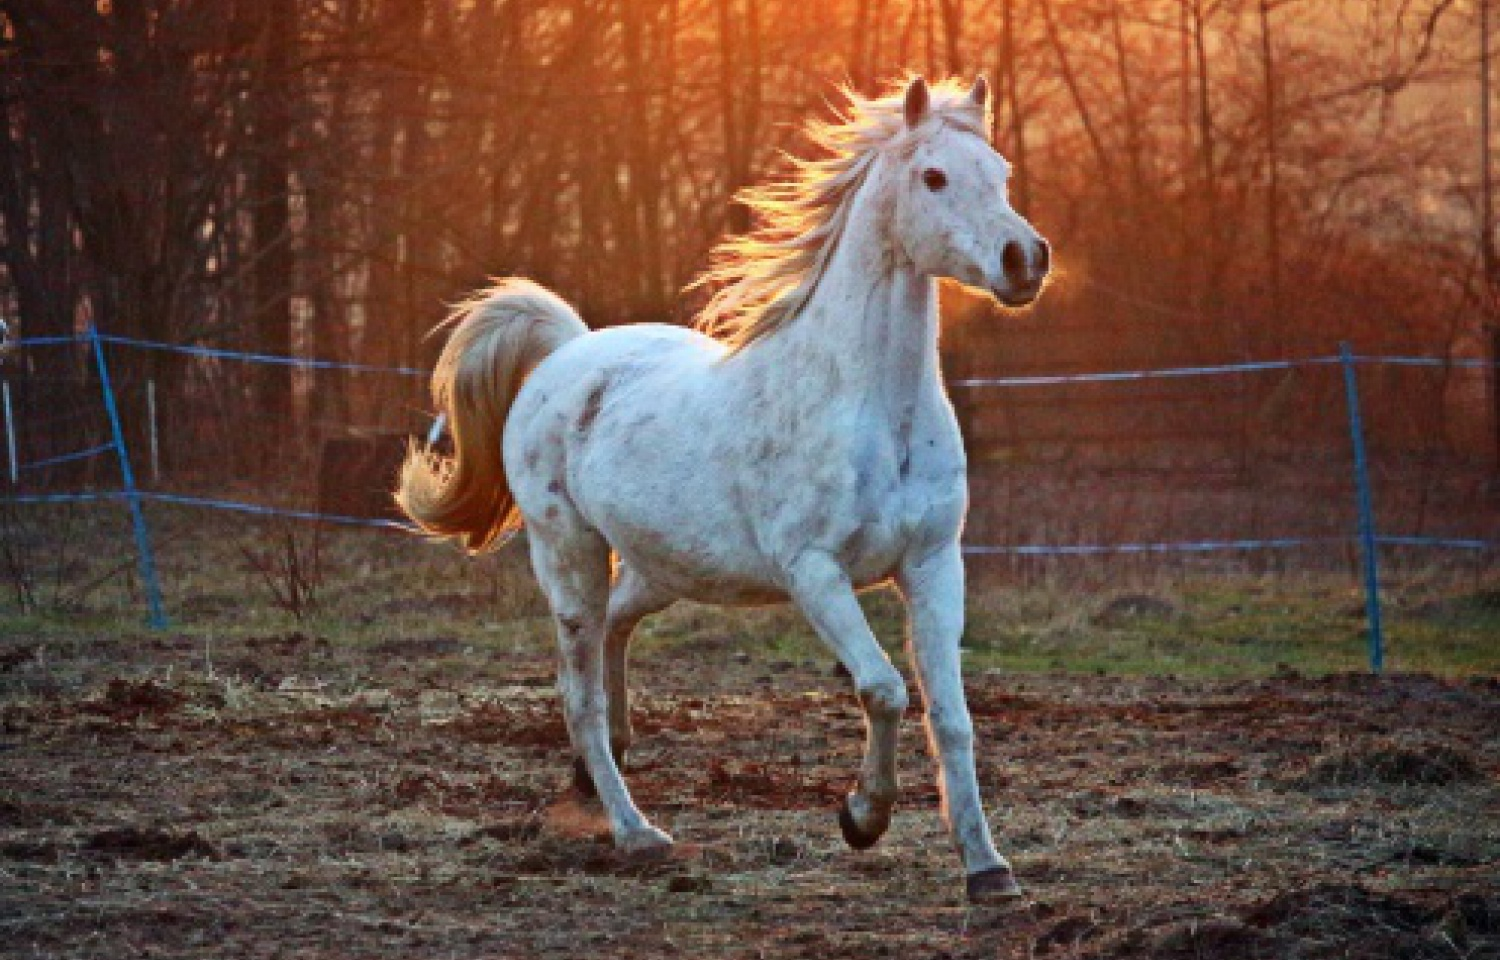

In [198]:
display.display(display.Image(filename=horseInFarm))
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:horseInFarm.jpg">Von.grzanka</a>'))


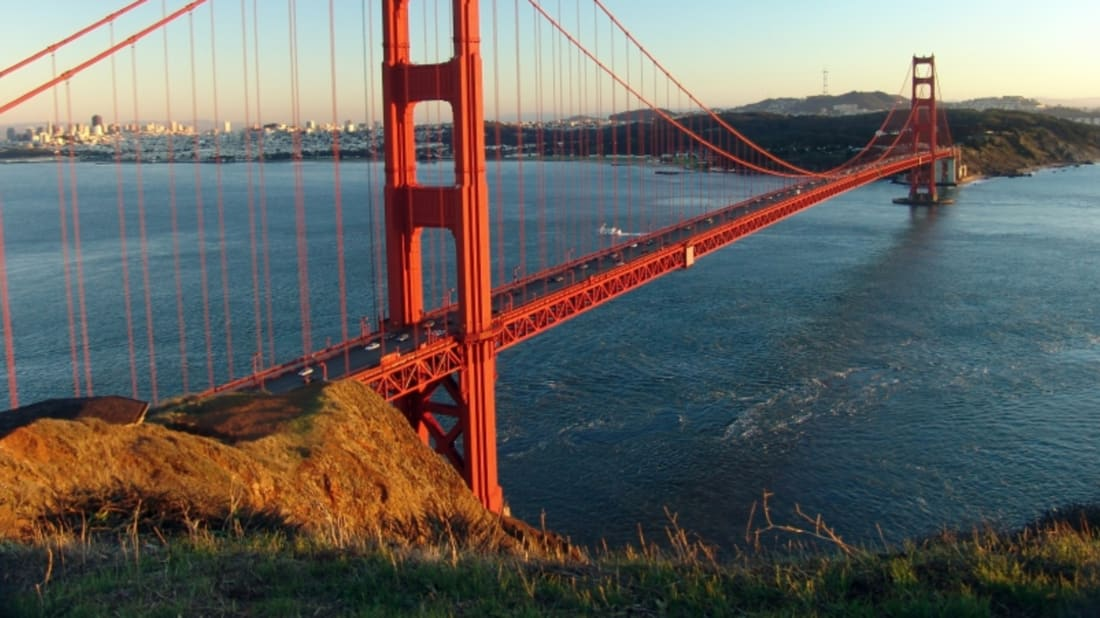

In [199]:
display.display(display.Image(filename=goldenBridge))
display.display(display.HTML('<a "href=https://commons.wikimedia.org/wiki/File:goldenBridge.jpg">From Wikimedia</a>'))


In [0]:
image_labels = {
    horseInFarm : 0,
    goldenBridge : 1,
}

In [201]:
# This is an example, just using the cat image.
image_string = open(horseInFarm, 'rb').read()

label = image_labels[horseInFarm]

# Create a dictionary with features that may be relevant.
def image_example(image_string, label):
  image_shape = tf.image.decode_jpeg(image_string).shape

  feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
  }

  return tf.train.Example(features=tf.train.Features(feature=feature))

for line in str(image_example(image_string, label)).split('\n')[:15]:
  print(line)
print('...')

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 960
      }
...


In [0]:
# Write the raw image files to `images.tfrecords`.
# First, process the two images into `tf.Example` messages.
# Then, write to a `.tfrecords` file.
record_file = 'images.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
  for filename, label in image_labels.items():
    image_string = open(filename, 'rb').read()
    tf_example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())

In [0]:
# du -sh {record_file}


In [204]:
raw_image_dataset = tf.data.TFRecordDataset('images.tfrecords')

# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {depth: (), height: (), image_raw: (), label: (), width: ()}, types: {depth: tf.int64, height: tf.int64, image_raw: tf.string, label: tf.int64, width: tf.int64}>

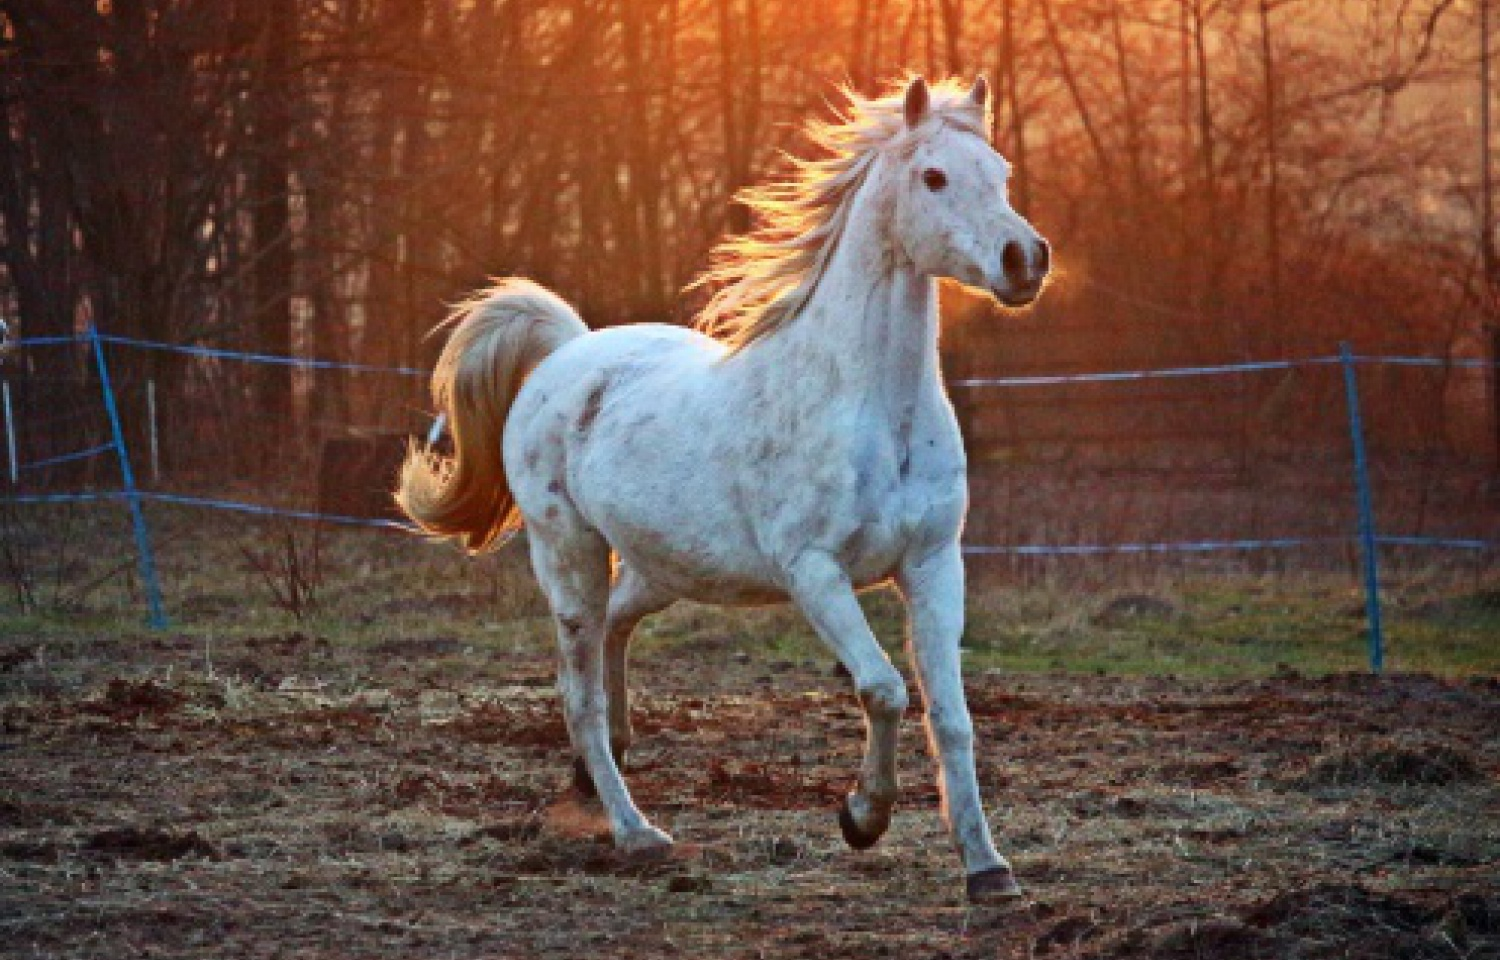

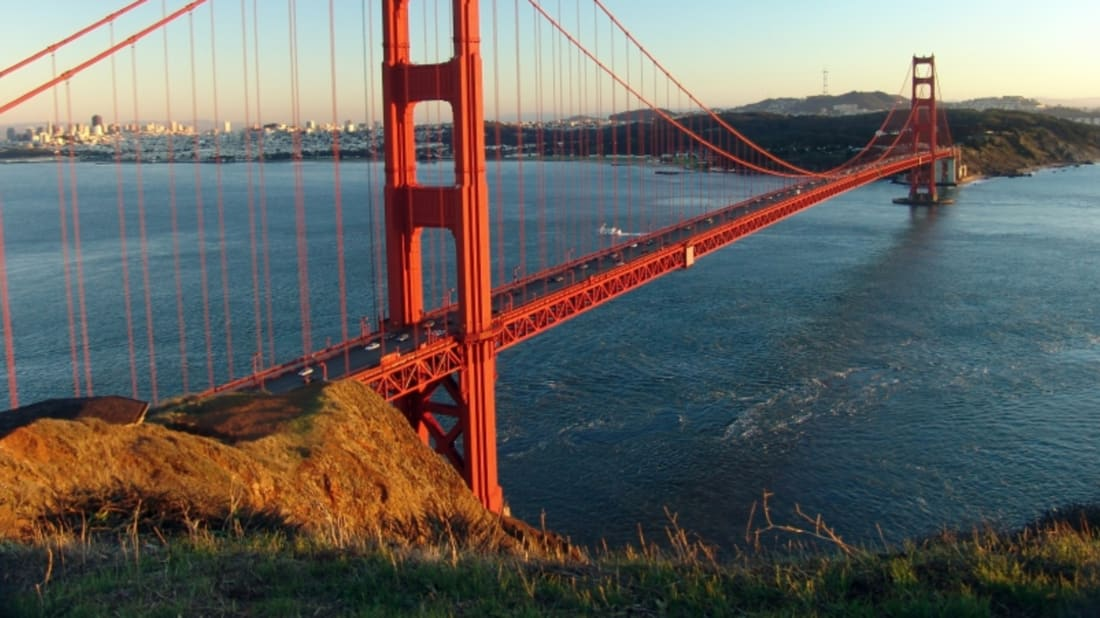

In [205]:
for image_features in parsed_image_dataset:
  image_raw = image_features['image_raw'].numpy()
  display.display(display.Image(data=image_raw))

# Customization basics: tensors and operations

In [0]:
import tensorflow as tf


In [207]:
print(tf.add(1, 2))
print(tf.add([1, 2], [3, 4]))
print(tf.square(5))
print(tf.reduce_sum([1, 2, 3]))

# Operator overloading is also supported
print(tf.square(2) + tf.square(3))

tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor([4 6], shape=(2,), dtype=int32)
tf.Tensor(25, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(13, shape=(), dtype=int32)


In [208]:
x = tf.matmul([[1]], [[2, 3]])
print(x)
print(x.shape)
print(x.dtype)

tf.Tensor([[2 3]], shape=(1, 2), dtype=int32)
(1, 2)
<dtype: 'int32'>


In [209]:
import numpy as np

ndarray = np.ones([3, 3])

print("TensorFlow operations convert numpy arrays to Tensors automatically")
tensor = tf.multiply(ndarray, 42)
print(tensor)


print("And NumPy operations convert Tensors to numpy arrays automatically")
print(np.add(tensor, 1))

print("The .numpy() method explicitly converts a Tensor to a numpy array")
print(tensor.numpy())

TensorFlow operations convert numpy arrays to Tensors automatically
tf.Tensor(
[[42. 42. 42.]
 [42. 42. 42.]
 [42. 42. 42.]], shape=(3, 3), dtype=float64)
And NumPy operations convert Tensors to numpy arrays automatically
[[43. 43. 43.]
 [43. 43. 43.]
 [43. 43. 43.]]
The .numpy() method explicitly converts a Tensor to a numpy array
[[42. 42. 42.]
 [42. 42. 42.]
 [42. 42. 42.]]


In [210]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.config.experimental.list_physical_devices("GPU"))

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

Is there a GPU available: 
[]
Is the Tensor on GPU #0:  
False


In [211]:
import time

def time_matmul(x):
  start = time.time()
  for loop in range(10):
    tf.matmul(x, x)

  result = time.time()-start

  print("10 loops: {:0.2f}ms".format(1000*result))

# Force execution on CPU
print("On CPU:")
with tf.device("CPU:0"):
  x = tf.random.uniform([1000, 1000])
  assert x.device.endswith("CPU:0")
  time_matmul(x)

# Force execution on GPU #0 if available
if tf.config.experimental.list_physical_devices("GPU"):
  print("On GPU:")
  with tf.device("GPU:0"): # Or GPU:1 for the 2nd GPU, GPU:2 for the 3rd etc.
    x = tf.random.uniform([1000, 1000])
    assert x.device.endswith("GPU:0")
    time_matmul(x)

On CPU:
10 loops: 345.10ms


In [0]:
ds_tensors = tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5, 6])

# Create a CSV file
import tempfile
_, filename = tempfile.mkstemp()

with open(filename, 'w') as f:
  f.write("""Line 1
Line 2
Line 3
  """)

ds_file = tf.data.TextLineDataset(filename)

In [0]:
ds_tensors = ds_tensors.map(tf.square).shuffle(2).batch(2)

ds_file = ds_file.batch(2)

In [215]:
print('Elements of ds_tensors:')
for x in ds_tensors:
  print(x)

print('\nElements in ds_file:')
for x in ds_file:
  print(x)

Elements of ds_tensors:
tf.Tensor([4 1], shape=(2,), dtype=int32)
tf.Tensor([ 9 16], shape=(2,), dtype=int32)
tf.Tensor([36 25], shape=(2,), dtype=int32)

Elements in ds_file:
tf.Tensor([b'Line 1' b'Line 2'], shape=(2,), dtype=string)
tf.Tensor([b'Line 3' b'  '], shape=(2,), dtype=string)


In [0]:
# the end